# MMC Implementation

## Correct Implementation

In [1]:
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import skmob
from tqdm import tqdm
import sys
sys.path.append('../')
from src.geo_utils import (get_clusters_from_tdf,
                            assign_tdf_points_to_clusters,
                            get_mmc_transitions,
                            get_stationary_vector)


In [9]:
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

### Evaluation of Implementation

In [128]:
# Reading 10 frames
data = pd.read_csv('../data/geo_000_009.csv.zip')

geo_columns = ['user', 'hour', 'lat', 'lng']

data['hour'] = data['date'] + ' ' + data['time']
data['hour'] = pd.to_datetime(data['hour'])

data['user'] = data['user_id'].map(int)

data = data[geo_columns]
data = data.drop_duplicates()
data = data.groupby(['user','hour'], as_index=False).nth(0)

In [133]:
user = data[data['user']==1]
user = user.sort_values('hour')

<AxesSubplot:xlabel='lat', ylabel='lng'>

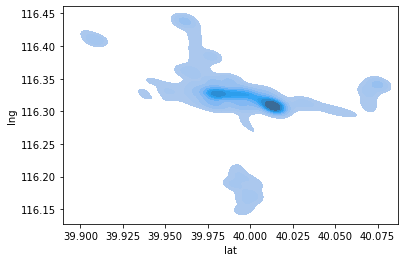

In [11]:
sns.kdeplot(data=user, x='lat',y='lng', fill=True)

In [149]:
data['seconds_diff'] = data.groupby('user')['hour'].diff(1).dt.seconds

In [150]:
data['seconds_diff'].value_counts(normalize=True).cumsum().head(20)

5.0     0.754824
2.0     0.831026
1.0     0.900795
3.0     0.969252
4.0     0.989184
10.0    0.990323
6.0     0.991101
15.0    0.991637
20.0    0.991989
25.0    0.992241
30.0    0.992455
35.0    0.992614
40.0    0.992747
8.0     0.992859
45.0    0.992969
50.0    0.993075
7.0     0.993164
55.0    0.993247
65.0    0.993318
60.0    0.993388
Name: seconds_diff, dtype: float64

In [151]:
data['seconds_diff'].value_counts(normalize=False).head(30)

5.0      1392072
2.0       140534
1.0       128671
3.0       126251
4.0        36759
10.0        2100
6.0         1436
15.0         988
20.0         648
25.0         465
30.0         395
35.0         294
40.0         244
8.0          207
45.0         204
50.0         195
7.0          164
55.0         152
65.0         131
60.0         130
195.0        124
205.0        112
75.0         112
180.0        110
185.0        106
190.0        105
70.0         104
80.0         100
200.0         98
215.0         97
Name: seconds_diff, dtype: int64

- El 99% de los registros están distanciados entre 0 y 5 segundos

In [192]:
data['seconds_diff'].nlargest(30)

7614       86049.0
507425     85665.0
1785004    85427.0
512970     85231.0
1569640    85065.0
451395     85048.0
1775221    84923.0
1395057    84589.0
1072280    84519.0
12942      84457.0
695895     84426.0
1508024    84248.0
1555866    84166.0
1727969    83731.0
518430     83384.0
1758294    83125.0
408196     83070.0
1769727    82727.0
1563363    82658.0
1625746    82403.0
757012     82228.0
1794658    82037.0
414638     81928.0
495151     81844.0
514374     81386.0
1705167    80655.0
1562119    80125.0
1140719    79925.0
91655      79870.0
933705     79870.0
Name: seconds_diff, dtype: float64

In [152]:
data[['lat_last','lng_last']] = data.groupby('user').shift(1)[['lat','lng']]

In [153]:
data

,user,hour,lat,lng,seconds_diff,lat_last,lng_last,distance_to_last_km
0,0,2008-10-23 02:53:04,39.984702,116.318417,NaN,NaN,NaN,NaN
1,0,2008-10-23 02:53:10,39.984683,116.318450,6.0,39.984702,116.318417,0.003517
2,0,2008-10-23 02:53:15,39.984686,116.318417,5.0,39.984683,116.318450,0.002831
3,0,2008-10-23 02:53:20,39.984688,116.318385,5.0,39.984686,116.318417,0.002735
4,0,2008-10-23 02:53:25,39.984655,116.318263,5.0,39.984688,116.318385,0.011023
...,...,...,...,...,...,...,...,...
1845931,9,2008-12-14 11:17:49,40.002858,116.343537,248.0,40.002878,116.343872,0.028621
1845932,9,2008-12-14 11:17:54,40.002832,116.343495,5.0,40.002858,116.343537,0.004600
1845933,9,2008-12-14 11:17:59,40.002821,116.343437,5.0,40.002832,116.343495,0.005089
1845934,9,2008-12-14 11:18:04,40.002790,116.343383,5.0,40.002821,116.343437,0.005748


In [154]:
def get_distance(row):
    lat, lng, lat_last, lng_last = row['lat'], row['lng'], row['lat_last'], row['lng_last']
    return skmob.utils.utils.distance((lat, lng), (lat_last, lng_last))

In [155]:
data['distance_to_last_km'] = data.apply(get_distance, axis=1) 
data['speed_mps'] = data['distance_to_last_km'] / data['seconds_diff'] * 1000

<AxesSubplot:>

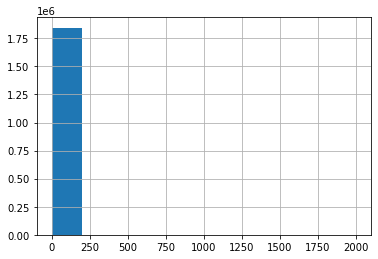

In [156]:
data['distance_to_last_km'].hist()

-------|-----|-----------|---------|

--xxXx--|--xX-x--|--x--xX--|

In [194]:
data['distance_to_last_km'].nlargest(30)

1525575    2001.218375
1520070    1994.344900
97123      1081.669208
939173     1081.669208
1346992    1081.536654
150130     1077.944217
992180     1077.944217
1352858    1076.852294
160679     1075.844012
1002729    1075.844012
102798     1075.794203
944848     1075.794203
834474      572.986636
423067      541.871785
1170042     442.393688
1558080     426.398341
1560352     426.291883
750317      394.941580
447718      231.795536
847476      190.899617
446666      165.851492
1569640     118.908134
1569088      90.527781
1616976      77.289171
1612317      71.716266
447251       64.190462
1596208      30.764803
460192       26.282796
1649785      22.989909
673294       22.801299
Name: distance_to_last_km, dtype: float64

<AxesSubplot:>

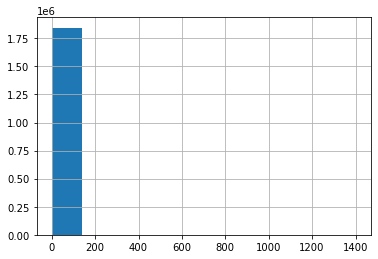

In [188]:
data['speed_mps'].hist()

<AxesSubplot:xlabel='distance_to_last_km'>

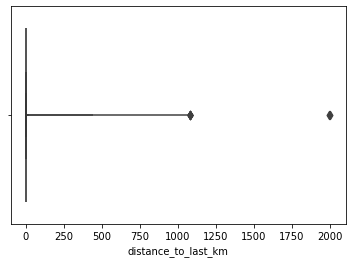

In [157]:
sns.boxenplot(data['distance_to_last_km'])

In [165]:
data[data['user']==3]['distance_to_last_km'].nlargest()

939173     1081.669208
992180     1077.944217
1002729    1075.844012
944848     1075.794203
834474      572.986636
Name: distance_to_last_km, dtype: float64

In [167]:
data[data['user']==3]['seconds_diff'].nlargest(20)

695895     84426.0
757012     82228.0
933705     79870.0
544295     79768.0
676862     79037.0
630893     78567.0
655347     77877.0
689334     74954.0
945408     73473.0
755736     73311.0
728441     73230.0
919711     71812.0
1013172    71351.0
985749     70516.0
936654     68931.0
987613     68840.0
709241     66907.0
927938     65308.0
977199     65025.0
616552     64782.0
Name: seconds_diff, dtype: float64

In [161]:
data['distance_to_last_km'].nlargest(20)

1525575    2001.218375
1520070    1994.344900
97123      1081.669208
939173     1081.669208
1346992    1081.536654
150130     1077.944217
992180     1077.944217
1352858    1076.852294
160679     1075.844012
1002729    1075.844012
102798     1075.794203
944848     1075.794203
834474      572.986636
423067      541.871785
1170042     442.393688
1558080     426.398341
1560352     426.291883
750317      394.941580
447718      231.795536
847476      190.899617
Name: distance_to_last_km, dtype: float64

In [158]:
data[data['distance_to_last_km']==data['distance_to_last_km'].max()]

,user,hour,lat,lng,seconds_diff,lat_last,lng_last,distance_to_last_km
1525575,5,2008-12-04 09:48:05,40.004663,116.322377,35306.0,22.161496,113.553496,2001.218375


In [144]:
data['distance_to_last_km'].value_counts()

0.000000    91694
0.000111     5590
0.000111     3374
0.000222     3246
0.000334     3048
            ...  
0.007101        1
0.006650        1
0.012126        1
0.010262        1
0.015240        1
Name: distance_to_last_km, Length: 1553660, dtype: int64

In [145]:
data['distance_to_last_km'].value_counts(normalize=True)*100

0.000000    4.971913
0.000111    0.303106
0.000111    0.182948
0.000222    0.176007
0.000334    0.165271
              ...   
0.007101    0.000054
0.006650    0.000054
0.012126    0.000054
0.010262    0.000054
0.015240    0.000054
Name: distance_to_last_km, Length: 1553660, dtype: float64

- La mayor parte de los datos no presenta movimiento (mismo punto) --> 5% de los datos

In [115]:
data['distance_to_last_km'].median()

0.006742996098370636

In [123]:
data['distance_to_last_km']

0               NaN
1          0.003517
2          0.002831
3          0.002735
4          0.011023
             ...   
1845931    0.028621
1845932    0.004600
1845933    0.005089
1845934    0.005748
1845935    0.005035
Name: distance_to_last_km, Length: 1845936, dtype: float64

In [126]:
data[data['seconds_diff']==0]

,user,hour,lat,lng,seconds_diff,lat_last,lng_last,distance_to_last_km
311762,2,2008-11-01 01:09:31,39.895870,116.272962,0.0,39.895867,116.272799,0.013910
426028,2,2009-01-25 05:26:27,37.416802,110.772034,0.0,37.416330,110.771849,0.054968
518710,2,2009-03-12 13:43:40,39.902545,116.368070,0.0,39.902621,116.368067,0.008455
1654187,7,2008-11-21 05:51:03,39.980499,116.351214,0.0,39.980499,116.351214,0.000000
1654189,7,2008-11-21 05:51:08,39.980469,116.351150,0.0,39.980469,116.351150,0.000000
...,...,...,...,...,...,...,...,...
1657571,7,2008-11-21 17:04:40,39.976264,116.338867,0.0,39.976264,116.338867,0.000000
1657573,7,2008-11-21 17:04:45,39.976411,116.339053,0.0,39.976411,116.339053,0.000000
1722973,8,2008-11-12 07:08:32,40.048065,116.280983,0.0,40.048333,116.281241,0.037018
1754618,8,2008-12-06 11:53:04,39.982005,116.328603,0.0,39.982012,116.328626,0.002109


In [183]:
data[(data['seconds_diff']>3600) & (data['distance_to_last_km']>1)]

,user,hour,lat,lng,seconds_diff,lat_last,lng_last,distance_to_last_km
148,0,2008-10-23 04:08:07,39.995777,116.286798,3772.0,39.984019,116.298663,1.652609
1152,0,2008-10-26 13:44:07,39.907414,116.370017,39421.0,40.009209,116.321162,12.060713
1897,0,2008-10-27 11:54:49,39.994622,116.326757,75042.0,39.926426,116.320399,7.602386
1947,0,2008-10-28 00:38:26,40.012290,116.297072,45152.0,40.008796,116.321834,2.144396
3424,0,2008-10-29 09:21:38,39.994238,116.326786,15476.0,40.007298,116.319285,1.586547
...,...,...,...,...,...,...,...,...
1736739,8,2008-11-18 01:51:32,39.957882,116.359849,6146.0,39.978441,116.352295,2.374967
1785004,9,2008-11-06 11:15:04,39.996149,116.328740,85427.0,40.002481,116.344464,1.513175
1823375,9,2008-12-06 11:21:05,40.002778,116.344249,4373.0,39.995886,116.328075,1.576518
1823952,9,2008-12-06 13:57:06,40.001054,116.342519,7200.0,39.991538,116.333163,1.324701


- Se cortará una trayectoria si el registro se detiene 1 hora. Valido? (¿?)

In [116]:
data['distance_to_last_km'].mean()

0.028380884647232086

In [121]:
(data['distance_to_last_km']>0.1).value_counts(normalize=True)

False    0.970334
True     0.029666
Name: distance_to_last_km, dtype: float64

<AxesSubplot:>

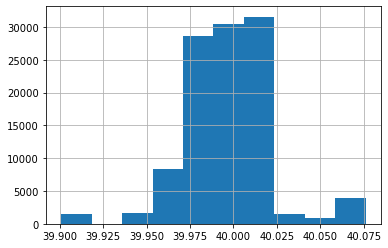

In [6]:
user['lat'].hist()

<AxesSubplot:>

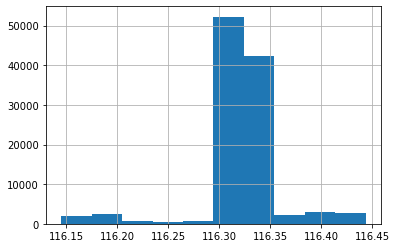

In [8]:
user['lng'].hist()